# 定义终端模型的网络结构 
以下自定义类myLSTM是本项目用于预测上证指数的LSTM网路结构

In [1]:
from pipeline.component.nn import save_to_fate

将自定义模型存入FATE的模型库中，存为myLSTM.py

In [2]:
%%save_to_fate model myLSTM.py
import torch
from torch.autograd import Variable


class myLSTM(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim) -> None:
        super(myLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=in_dim, hidden_size=hidden_dim)
        self.liner = torch.nn.Linear(in_features=hidden_dim, out_features=out_dim) 
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim

    def forward(self, seq):
        h_0 = Variable(torch.zeros(1, 1, self.hidden_dim).cpu())
        c_0 = Variable(torch.zeros(1, 1, self.hidden_dim).cpu())
        lstm_out, (hidden_state, cell_state) = self.lstm(seq.view(len(seq),1,-1),(h_0,c_0))
    
        prediction = self.liner(hidden_state[-1])
        return prediction

# 获取训练数据
从雅虎财经上获取2013-2022年的上证指数数据，并将其可视化

In [3]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import yfinance as yf
yf.pdr_override()

In [4]:
def Date_cut(df, start_date = '2013-01-01', end_date = '2022-12-31'):
    return df.loc[(df.index >= start_date) & (df.index<= end_date)]

SSE_start = '2013-01-01'
SSE_end =  '2022-12-31'

df_SSE = data.get_data_yahoo(tickers='000001.ss',start='2013-01-01', end='2022-12-31')
df_SSE = Date_cut(df_SSE, SSE_start, SSE_end)
print("SSE data size:", len(df_SSE.index))


[*********************100%%**********************]  1 of 1 completed
SSE data size: 2427


/data/projects/fate/env/python/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 65509 (\N{FULLWIDTH YEN SIGN}) missing from current font.
  func(*args, **kwargs)
/data/projects/fate/env/python/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65509 (\N{FULLWIDTH YEN SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


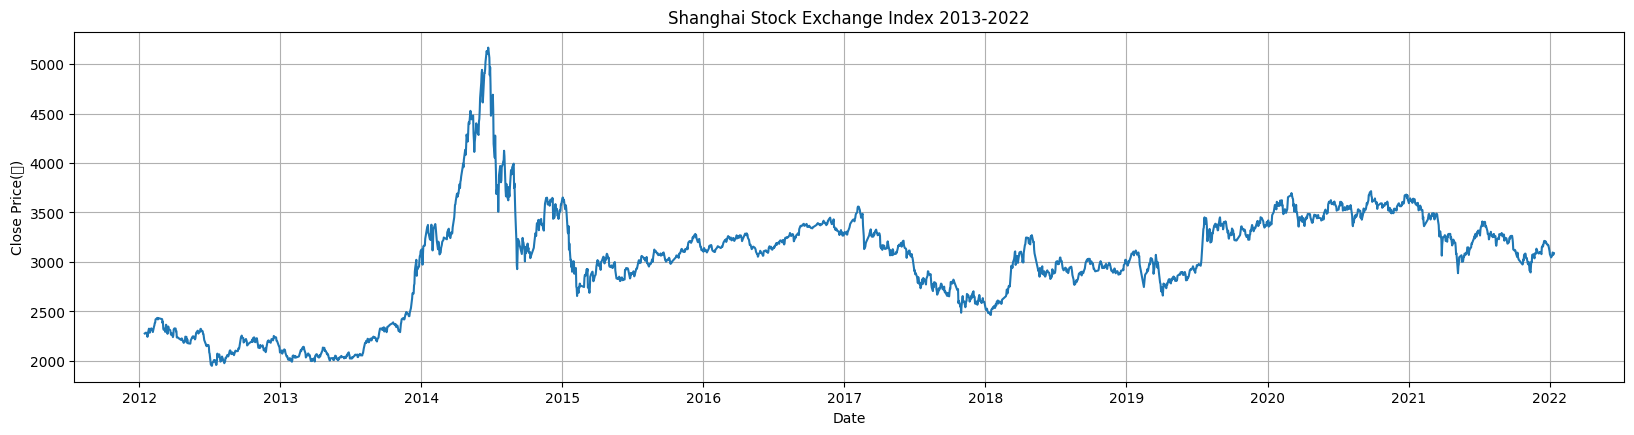

In [5]:
tick_spacing = 365
fig = plt.figure(figsize = (20,10))
sse = fig.add_subplot(211)
sse.set_title("Shanghai Stock Exchange Index 2013-2022")
sse.set_xlabel("Date")
sse.set_ylabel("Close Price(￥)")
sse.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing ))
sse.plot(df_SSE.loc[:,"Close"])
# sse.plot(df_SSE)
sse.grid()

# 分割数据集，以其中80%作为训练集，20%作为测试集

In [6]:
train_proportial = 0.8

close = df_SSE.loc[:,"Close"]
training_size=int(len(close)*train_proportial)
train_data = close[:training_size]
test_data = close[training_size:]


from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
train_data_normalized = scaler.fit_transform(np.array(train_data).reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

以下是用于数据处理的函数，将原始数据处理成可以喂给自定义模型的数据结构

In [7]:
def make_xySeq(tran_data, window_size=10, predict_gap=5):
    xySeq = []
    for i in range(len(tran_data)-window_size-predict_gap):
        x = tran_data[i:i+window_size]
        y = tran_data[i+window_size+predict_gap]
        xySeq.append((x,y))
    return xySeq 

In [8]:
train_seq = make_xySeq(train_data_normalized)

创建myLSTM类的实例

In [9]:
network = myLSTM(10,100,1)
network

myLSTM(
  (lstm): LSTM(10, 100)
  (liner): Linear(in_features=100, out_features=1, bias=True)
)

# 将myLSTM模型转换为FATE框架的联邦学习模型

In [10]:
from federatedml.nn.homo.trainer.fedavg_trainer import FedAVGTrainer
trainer = FedAVGTrainer(epochs=100, batch_size=-1, shuffle=False, data_loader_worker=8, pin_memory=False) 
trainer.set_model(network) # set model

Try to Import DeepSpeed ERROR, Will Not Support Using DeepSpeed


使用FATE框架对转化后的模型进行本地训练

In [11]:
trainer.local_mode()

In [12]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
trainer.train(train_set=train_seq, optimizer=optimizer, loss=loss)

epoch is 0
total batch len is 1
  0%|                                                     | 0/1 [00:00<?, ?it/s]/data/projects/fate/env/python/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1926])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]
epoch is 1
total batch len is 1
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]
epoch is 2
total batch len is 1
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]
epoch is 3
total batch len is 1
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]
epoch is 4
total batch len is 1
100%|█████████████████████████████████████████████| 1/1 [00:00<00:

# 利用FATE框架调取训练后的终端模型，并可视化模型的预测结果

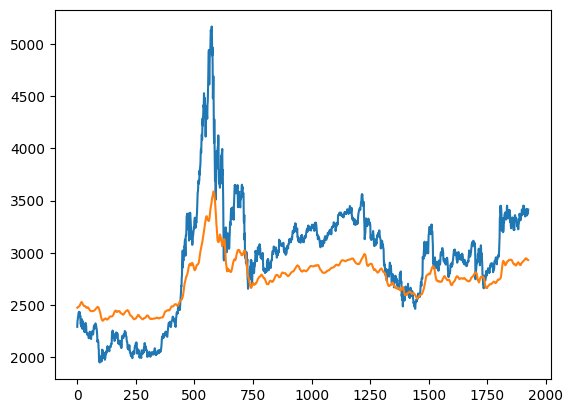

In [13]:


y_preds_train = []
y_gt = []
for x, y in train_seq:
    with torch.no_grad():
        x = x.repeat(1,10)
        x = x.view(10,-1)
        # print(x)
        y_hat = trainer.model(torch.unsqueeze(x,1)).item()
        y_preds_train.append(y_hat)
        y_gt.append(y)

y_preds_train = scaler.inverse_transform(np.array(y_preds_train).reshape(-1,1))
y_gt = scaler.inverse_transform(np.array(y_gt).reshape(-1,1))

plt.plot(y_gt)
plt.plot(y_preds_train)

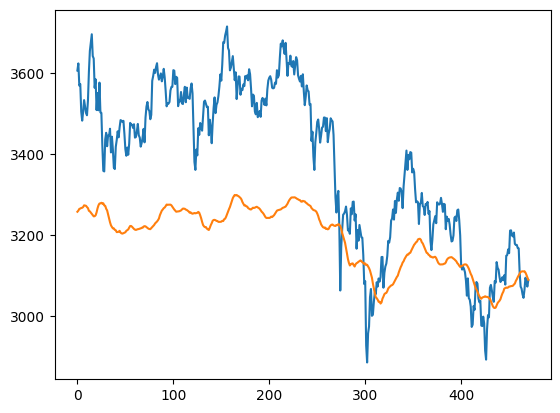

In [14]:
test_data_normalized = scaler.fit_transform(np.array(test_data).reshape(-1,1))
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_seq = make_xySeq(test_data_normalized)

y_preds_test = []
y_gt = []
for x, y in test_seq:
    with torch.no_grad():
        x = x.repeat(1,10)
        x = x.view(10,-1)
        y_hat = network(x).item()
        y_preds_test.append(y_hat)
        y_gt.append(y)

y_preds_test = scaler.inverse_transform(np.array(y_preds_test).reshape(-1,1))
y_gt = scaler.inverse_transform(np.array(y_gt).reshape(-1,1))

plt.plot(y_gt)
plt.plot(y_preds_test)